# NDVI 

Normalised difference vegetaion index

# OpenCV / cv2 

https://docs.opencv.org/master/d1/dfb/intro.html 

### OpenCV docs
open source computer vision library: python wrapper for original OpenCV C/C++ API/library/thing
https://readthedocs.org/projects/opencv-python-tutroals/downloads/pdf/latest/

Equations for colour spectrum conversion
https://docs.opencv.org/master/de/d25/imgproc_color_conversions.html#color_convert_rgb_hsv


I was able to install opencv from conda forge (I think), have just tried import cv2 below, and it just worked. Conclude this is another irritating case of python module name for install being different to import name. Why would anyone do this? Maybe to do with updates.

## APGB CIR brief user guide:

https://support.apgb.co.uk/en/article/apgb-colour-infrared-cir-user-guide

The Aerial Photography CIR Product comprises a digital spatial product:  

A colour infra-red orthophoto product at 50cm resolution, provided as tiles, colour enhanced to maximise information content and colour balanced to be consistent regionally. This product allows digital viewing in mono mode, for mono-plotting, data extraction and production of vegetation indices.  

The product comprises 3 bands as follows:   

| Band     | Description           | Spectral Range   |
|:---------|:----------------------|:-----------------|
| NIRF18A  | Near Infrared (NIR)   | 690 - 1000nm       |     
| REDF14A  | Red                   | 580 - 700nm        |     
| GRNF16A  | Green                 | 480 - 630nm        |

NIR will be displayed on monitors as Red, Red is displayed as Green and Green is displayed as Blue.


## Green Spaces HSV: Vegetation Analysis line 476

Notes from line 476 of green_spaces vegetation analysis by Matt Rickets (OS), worked with Chris Bonham and Sonja Williams (both ONS).
https://github.com/datasciencecampus/green-spaces/blob/develop/green_spaces/vegetation_analysis.py

c/o Matt Rickets:
"""
        c/o Matt:
        1. Rearrange bands from RGB+I to I G B (in that order, discarding red).
        2. Convert this rearranged banded image to HSV colour space    
            (I used:  hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        3. Define and append the lower and upper values of ‘red’ to variables (as we’re casting the IR signal in to 
            the red band, so then on thresholding based on intensity of red). 
            I used: (RED_MIN = np.array([0, 125, 20],np.uint8) <and> RED_MAX = np.array([10, 255, 255],np.uint8). 
            I think the value of RED_MAX could be tweaked to capture really dark red areas (shadows) where an IR signal 
            still exists beneath (albeit weak).
        4. I then did the thresholding using
            frame_threshed = cv2.inRange(hsv_img, RED_MIN, RED_MAX)
        5. With the binary layer that this produces I derived % of each class (urban vs. vegetation) using pixel count 
            against total pixel count per garden.
        Note that images are records in R,G,B,Ir format, but are loaded in order of B, G, R, Ir
        :param bgri_image: 3D array of blue, green, red, infra red values each in the range 0..255, of the image to be
            analysed, of the form [height, width, 4] ordered near blue, green, red, infrared
        :return: vegetation index of 0 or 1, indicating vegetation true or false
        """

## Colour-Infrared (CIR)

https://www.usgs.gov/faqs/what-do-different-colors-a-color-infrared-aerial-photograph-represent?qt-news_science_products=0#qt-news_science_products

Not having much luck finding resources about this stuff. 

What do the different colors in a color-infrared aerial photograph represent?
Color-infrared (CIR) aerial photography--often called "false color" photography because it renders the scene in colors not normally seen by the human eye--is widely used for interpretation of natural resources. Atmospheric haze does not interfere with the acquisition of the image.

Live vegetation is almost always associated with red tones. Very intense reds indicate dense, vigorously growing vegetation. As plant vigor decreases, the vegetation appears as lighter shades of red and pink, various shades of greens, and possibly tans. 

Bare soils appear as shades of white, blue, or green in most agricultural regions. In general, darker shades of each color indicate moister soil.

Man-made features appear in tones that relate to the materials with which they are made. Asphalt roads, for example, are dark blue or black; gravel or dirt roads are lighter colors depending on their composition; and clean concrete roads are light in tone. The colors of buildings are similarly dependent on the materials used to create them.

Water appears as shades of blue, varying from nearly black (clear, clean water) to very pale blue (increasing amounts of sediment). The color of very shallow water is often determined by the material present at the bottom of the water. For example, a very shallow stream with a sandy bottom will appear white due to the high level of sand reflection.

### Green spaces NDVI excerpt

https://datasciencecampus.ons.gov.uk/projects/green-spaces-in-residential-gardens/

#### NDVI
The Normalised Difference Vegetation Index (NDVI) calculates the normalised difference between the red and infrared bands for quantitative and standardised measurement of vegetation presence and health (Deering and others, 1975). Healthy vegetation has a high reflectance of Near-Infrared wavelengths and greater absorption of red wavelengths due to a greater chlorophyll composition (see Figure 22).

The Near-Infrared (NIR) and red (R) spectral channels of an image are used to calculate an index value, using the following equation,

𝑁𝐷𝑉𝐼 = (𝑁𝐼𝑅−𝑅) / (𝑁𝐼𝑅+𝑅)

The index ranges from -1 to 1. In this study, individual pixels with a value greater than 0 are classified as vegetation due to their higher reflectance of Near-Infrared. **The closer to 1 the healthier the vegetation and greatest density of green leaves**. vNDVI, in a similar manner to NDVI, is also sensitive to atmospheric effects, specifically cloud cover and should be atmospherically corrected when used in studies analysing change over time.

## Channel order !!!

Look at image specs to see what order the channels are in. For 25cm RGB they are in RGB order and for the CIR 50cm they are NIR, R, G.

### rasterio vs cv2

Both libraries read the data in in the order they are stored BUT cv2 then converts to 'BGR' order. So it expects the image to be in 'RGB' order then swaps the first and third channels.

That is for channels read in order 0,1,2
- 0 -> 2
- 1 -> 1
- 2 -> 0

#### RGB image
For the 25cm RGB images this means cv2 array stores them Blue, Green, Red

#### CIR image
For the 50cm NIR, Red, Green images this means cv2 array stores them Green, Red, NIR



## Libraries

In [1]:
import pickle #no idea what this is, but apparently I installed it
import cv2

import os
from os import path
import glob
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_column', 100) #set max number of cols to display before ...


#check correct environment is being used: parkprov
print(sys.executable)

/Users/tamsinforbes/anaconda3/envs/parkprov/bin/python


In [2]:
import rasterio
from rasterio._base import gdal_version
#https://rasterio.readthedocs.io/en/latest/
import rasterio.warp
import rasterio.features
from rasterio import plot #essential to plot images in BNG, in correct position, and full RGB 

from rasterio.mask import mask

In [3]:
import folium
import fiona
import pyproj
import shapely as shp


In [4]:
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

In [5]:
import skimage.io #to read and write images
#import skimage.viewer #to view images; in new window; import matplotlib first - this is shit
import skimage.transform

## Load APGB NIR cropped gardens: irg_gdn_cropped

50cm APGB CIR/NIR images have near-Infra-red, Red and Green channels. Have to assume that it is read in in this order? How can I check?


In [6]:
irg_cg_paths = glob.glob(
    '../jigsaw_output/irg_gdn_cropped/*.tif', recursive=True)
irg_cg_paths[0:5]

['../jigsaw_output/irg_gdn_cropped/TQ1980_1000001778697829.tif',
 '../jigsaw_output/irg_gdn_cropped/TQ1980_5000005138038971.tif',
 '../jigsaw_output/irg_gdn_cropped/TQ1980_1000001778697815.tif',
 '../jigsaw_output/irg_gdn_cropped/TQ1980_1000001778701863.tif',
 '../jigsaw_output/irg_gdn_cropped/TQ1980_1000001778701877.tif']

In [7]:
#open one
irg = rasterio.open(irg_cg_paths[0])
print("path: ", irg.name, "\nmode: ", irg.mode, "\nis closed?: ", irg.closed
      , "\nband count: ", irg.count, "\nshape: ", irg.shape)

path:  ../jigsaw_output/irg_gdn_cropped/TQ1980_1000001778697829.tif 
mode:  r 
is closed?:  False 
band count:  3 
shape:  (20, 34)


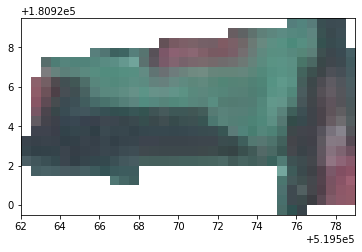

In [8]:
plot.show(irg)

In [111]:
irg.crs
#BNG

CRS.from_epsg(27700)

### Assign the IRG data array

This is the underlying 3D array of size 3 x height x width, where height and width have the number of pixels in tose directions. Note that the plotted image has CRS BNG so is in metres. So for the 50cm IRG images there are 2 pixels to every metre.

In [286]:
irg_data = irg.read().astype(np.float) #convert to float!!!

In [287]:
irg_data.shape

(3, 20, 34)

### Look at plot of each channel

They all look the same to me - are subtley different though

In [288]:
irg_data[0].shape

(20, 34)

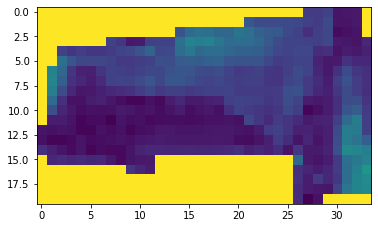

In [289]:
#NIR channel
plot.show(irg_data[0])

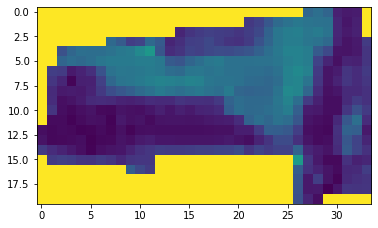

In [290]:
#Red channel
plot.show(irg_data[1])

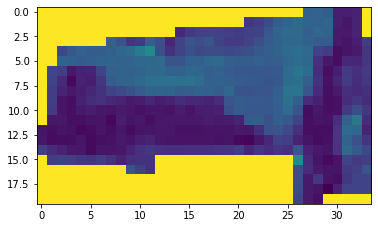

In [291]:
#Green channel
plot.show(irg_data[2])

## Load APGB RGB cropped gardens: rgb_gdn_cropped

25cm resolution contains Red, Green, Blue channels

In [15]:
rgb_cg_paths = glob.glob(
    '../jigsaw_output/rgb_gdn_cropped/*.tif', recursive=True)
rgb_cg_paths[0:5]

['../jigsaw_output/rgb_gdn_cropped/TQ1980_1000001778697829.tif',
 '../jigsaw_output/rgb_gdn_cropped/TQ1980_5000005138038971.tif',
 '../jigsaw_output/rgb_gdn_cropped/TQ1980_1000001778697815.tif',
 '../jigsaw_output/rgb_gdn_cropped/TQ1980_1000001778701863.tif',
 '../jigsaw_output/rgb_gdn_cropped/TQ1980_1000001778701877.tif']

In [16]:
rgb = rasterio.open(rgb_cg_paths[0])
print("path: ", rgb.name, "\nmode: ", rgb.mode, "\nis closed?: ", rgb.closed
      , "\nband count: ", rgb.count, "\nshape: ", rgb.shape)

path:  ../jigsaw_output/rgb_gdn_cropped/TQ1980_1000001778697829.tif 
mode:  r 
is closed?:  False 
band count:  3 
shape:  (39, 67)


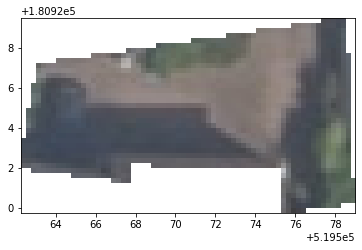

In [17]:
plot.show(rgb)

## Load cropped garden polygons

In [18]:
#cg: cropped gardens
#read in as strings
cg = pd.read_csv("../data/cropped_gardens.csv"
                 , dtype={'gdnTOID': object, 'geometry': object})
#convert WKT strings to geometry
cg['geometry'] = cg['geometry'].map(shp.wkt.loads)
#convert to geodataframe and set CRS
cg = gpd.GeoDataFrame(cg, crs="EPSG:27700", geometry="geometry")

In [19]:
cg.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: UK - Britain and UKCS 49°46'N to 61°01'N, 7°33'W to 3°33'E
- bounds: (-9.2, 49.75, 2.88, 61.14)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [20]:
cg.shape

(1329, 2)

In [21]:
cg.head()

,gdnTOID,geometry
0,0001000003513170,"POLYGON ((519327.150 180219.550, 519329.100 18..."
1,1000001778258479,"POLYGON ((519684.949 180970.923, 519685.728 18..."
2,1000001778258579,"POLYGON ((519666.761 180968.013, 519667.537 18..."
3,1000001778258580,"POLYGON ((519693.713 180972.325, 519694.467 18..."
4,1000001778258608,"POLYGON ((519712.133 180975.268, 519712.903 18..."


## List of cropped garden TOIDs

In [22]:
gdn_toids = cg['gdnTOID'].drop_duplicates().tolist()

In [23]:
len(gdn_toids)

1329

In [24]:
value, counts = np.unique(gdn_toids, return_counts=True)
sum(counts)

1329

## Load roadside edge LineStrings

In [25]:
#cg: cropped gardens
#read in as strings
rsls = pd.read_csv("../data/roadside_linestrings.csv"
                 , dtype={'gdnTOID': object, 'rsTOID': object, 'geometry': object})
#convert WKT strings to geometry
rsls['geometry'] = rsls['geometry'].map(shp.wkt.loads)
#convert to geodataframe and set CRS
rsls = gpd.GeoDataFrame(rsls, crs="EPSG:27700", geometry="geometry")

In [26]:
rsls.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: UK - Britain and UKCS 49°46'N to 61°01'N, 7°33'W to 3°33'E
- bounds: (-9.2, 49.75, 2.88, 61.14)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [27]:
rsls.shape

(1413, 3)

In [28]:
rsls.nunique()

gdnTOID     1413
rsTOID        59
geometry    1413
dtype: int64

In [29]:
rsls.head()

,gdnTOID,rsTOID,geometry
0,1000001778708314,1000001778708368,"LINESTRING (519791.500 179998.700, 519790.100 ..."
1,1000001778708315,1000001778708368,"LINESTRING (519795.850 180000.450, 519794.750 ..."
2,1000001778708617,1000001778708368,"LINESTRING (519799.200 180008.550, 519800.450 ..."
3,1000001778708317,1000001778708368,"LINESTRING (519800.450 180005.450, 519801.550 ..."
4,1000001778708000,1000001778708235,"LINESTRING (519590.300 179998.300, 519586.900 ..."


## Filter for just the cropped gardens

In [30]:
rsls = rsls[rsls['gdnTOID'].isin(gdn_toids)]
rsls.shape

(1329, 3)

In [31]:
rsls.head()

,gdnTOID,rsTOID,geometry
1,1000001778708315,1000001778708368,"LINESTRING (519795.850 180000.450, 519794.750 ..."
2,1000001778708617,1000001778708368,"LINESTRING (519799.200 180008.550, 519800.450 ..."
3,1000001778708317,1000001778708368,"LINESTRING (519800.450 180005.450, 519801.550 ..."
4,1000001778708000,1000001778708235,"LINESTRING (519590.300 179998.300, 519586.900 ..."
5,1000001778708002,1000001778708235,"LINESTRING (519593.300 180002.700, 519591.500 ..."


In [32]:
rsls.nunique()

gdnTOID     1329
rsTOID        58
geometry    1329
dtype: int64

## NDVI - using es.normalized_diff

### This didn't look right until I converted from int to .astype(np.float)

https://www.earthdatascience.org/courses/use-data-open-source-python/multispectral-remote-sensing/vegetation-indices-in-python/calculate-NDVI-python/

Use numpy to calculate (NIR - Red) / (NIR + Red) for each pixel in 50cm resolution image. Maybe should upsample first anyway...

At the moment I think the 0, 1, 2 channels in 50cm images are NIR, Red, Green respectively.

In [292]:
irg_data.shape

(3, 20, 34)

In [293]:
irg_data[:, 0:3, 0:3]

array([[[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]]])

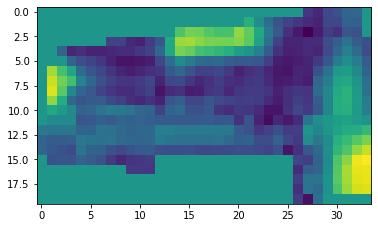

In [301]:
#NDVI: NIR & Red ratio 
irg_ndvi = es.normalized_diff(irg_data[0], irg_data[1])
plot.show(irg_ndvi)

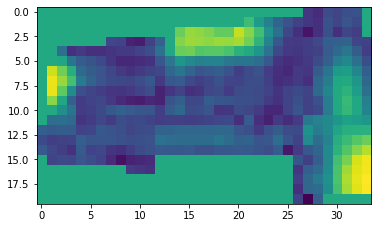

In [299]:
#NIR & Green ratio
plot.show(es.normalized_diff(irg_data[0], irg_data[2]))

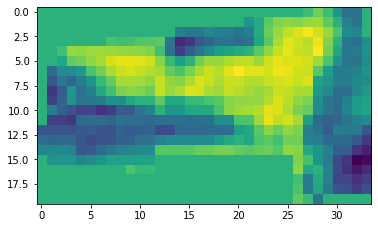

In [300]:
#Red & Green ratio
plot.show(es.normalized_diff(irg_data[1], irg_data[2]))

In [302]:
irg_ndvi.shape

(20, 34)

In [303]:
irg_ndvi[0:10, 0:10]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -0.18139535, -0.18181818, -0.2278481 ],
       [ 0.        ,  0.        , -0.1122449 , -0.23152709, -0.21658986,
        -0.23584906, -0.23584906, -0.2293578 , -0.21929825, -0.21888412],
       [ 0.        ,  0.        ,  0.        , -0.11587983, -0.15981735,
        -0.18018018, -0.20175439, -0.23684211, -0.26126126, -0.26126126],
       [ 0.        ,  0.1814346 ,  0.09952607,  0.03225806, -0.09589041,
        -0.14473684, -0.17021277, -0.20720721

In [304]:
print("min:"
      , np.amin(irg_ndvi[~np.isnan(irg_ndvi)])
      , "and max:"
      , np.amax(irg_ndvi[~np.isnan(irg_ndvi)])
     )


min: -0.2897196261682243 and max: 0.2579185520361991


### Hmmm...

As I understand it NDVI value means that vegetation is positive, close to 1
- why does my NDVI value contain values greater than 1, and no negatives? Because I hadn't converted to float and htis messed up the calculation.
- Green end is vegetation - pink isend is non-veg
- problem with calling the non-garden space white - now it blends in with the vegetation - actually this is a good thing - I want to ignore the space outiside the garden; so classing it as vegetation is OK I guess. If I did it the otherway round, it would look like manmade area and then might get include in parking polygons.
- vegetation reflects the NIR, it can't use these wavelengths for photosynthesis so reflects them. So vegetation should have high NIR values - hence look more green on this plot

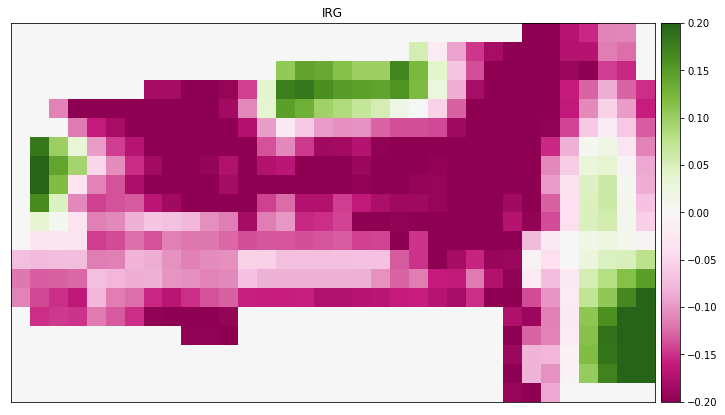

In [328]:
#NIR & Red
ep.plot_bands(irg_ndvi
              , cmap='PiYG'
              , scale=False
              , vmin=-0.2, vmax=0.2
              , title="IRG")
plt.show()
#quite clearly shows veg in shadow is not recognised, though it's difficult to tell from the RGB image also

## Run on 5 images: [0]: NIR, [1]:Red

I think the 0 channel is NIR and 1 is Red, so in the images below, green is vegetation, pink is non-veg

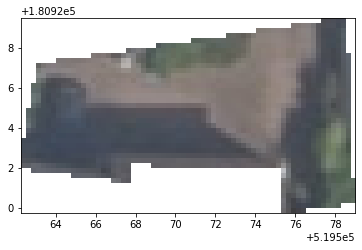

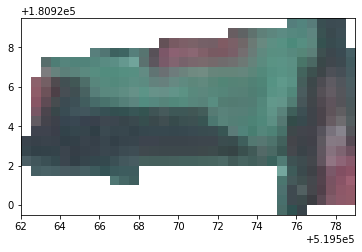

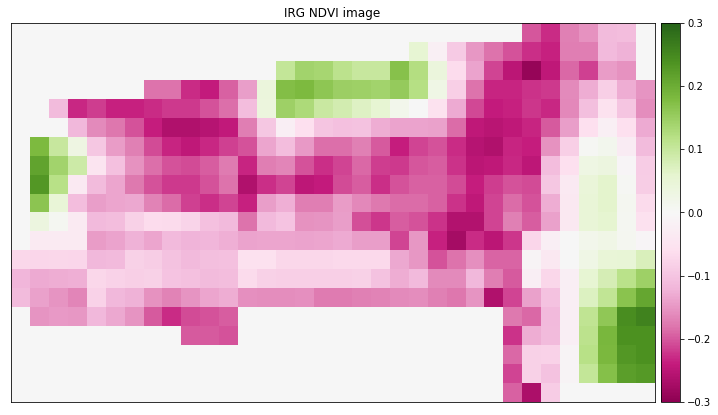

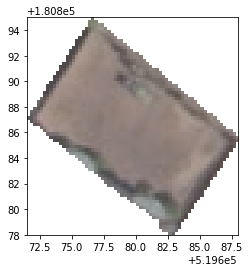

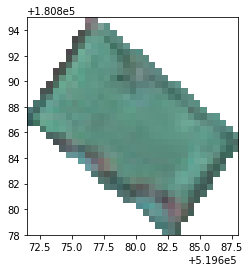

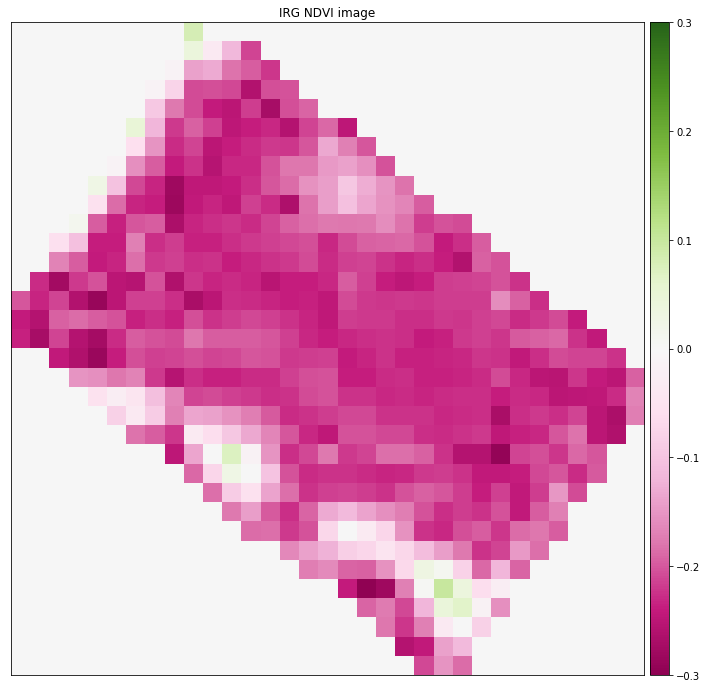

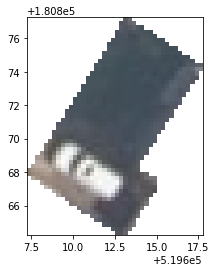

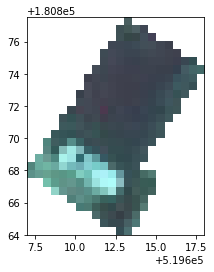

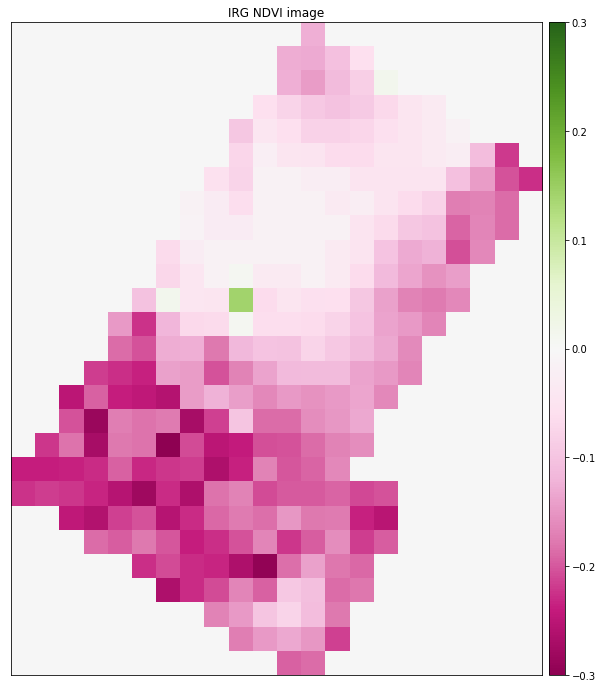

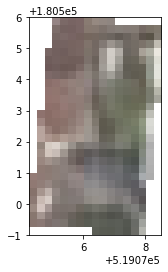

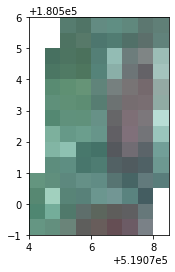

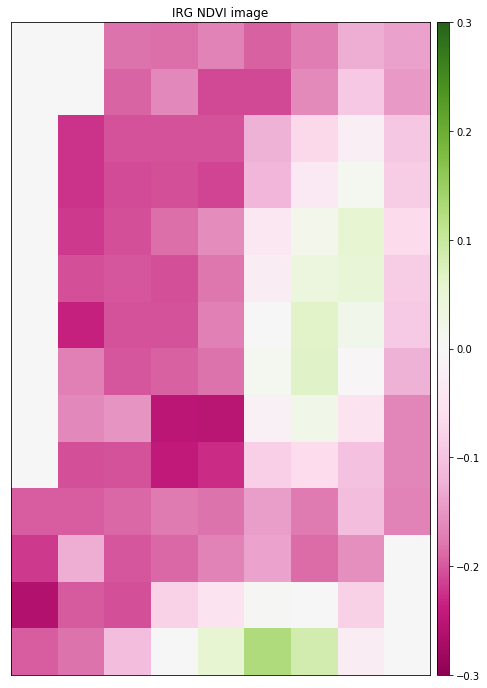

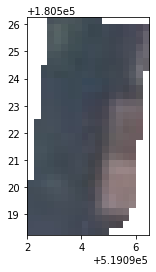

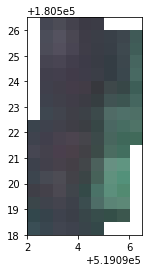

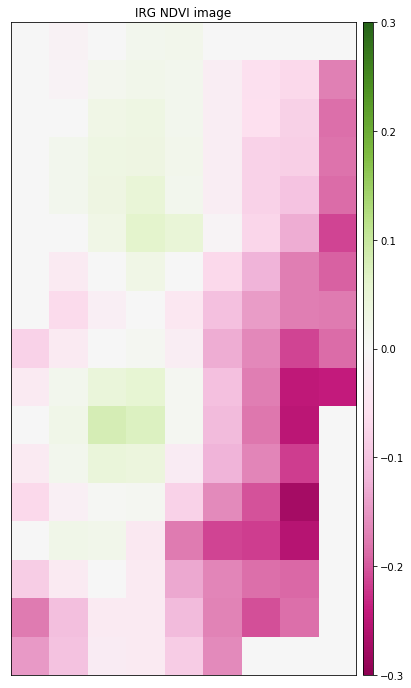

In [307]:
for i in np.arange(5):
    rgbim = rasterio.open(rgb_cg_paths[i]) #read RGB image
    plot.show(rgbim) #plot image

    im = rasterio.open(irg_cg_paths[i]) #read IRG image
    plot.show(im) #plot image
    im_data = im.read().astype(np.float) #assign data array to object & convert to float
    im_ndvi = es.normalized_diff(im_data[0], im_data[1]) #calc NDVI
    
    #plot
    ep.plot_bands(im_ndvi
              , cmap='PiYG' #a diverging colourmap
              , scale=False
              , vmin=-0.3, vmax=0.3
              , title="IRG NDVI image")
    plt.show()
    

## Run on 5 images: [0]:Red, [1]:NIR

Now this looks right - this is negative of the above, with (Red - NIR) / (NIR + Red + 0.001), so the vegetation now shows as pink and the non-veg as green. Phew.


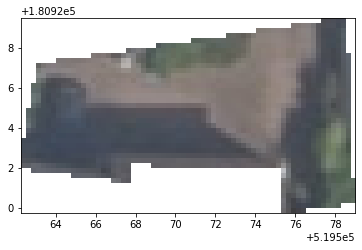

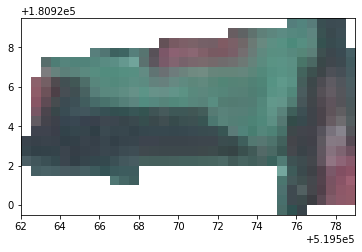

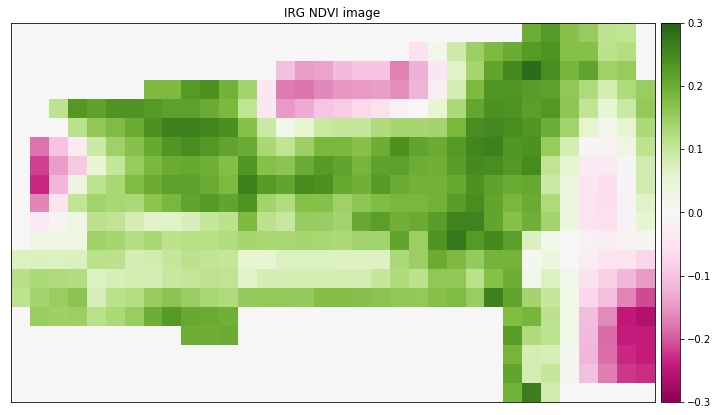

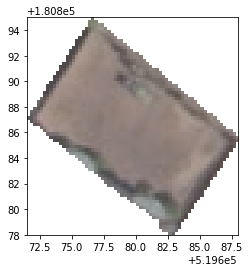

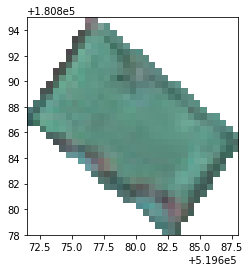

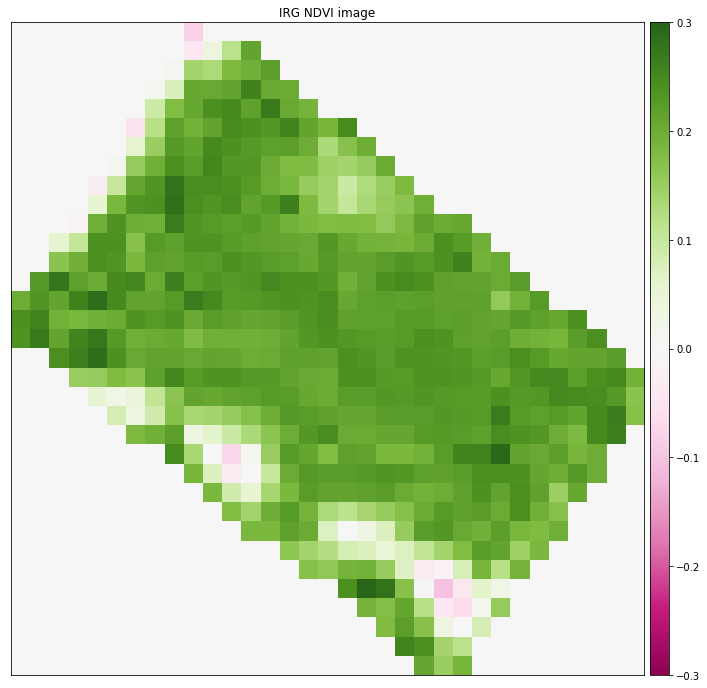

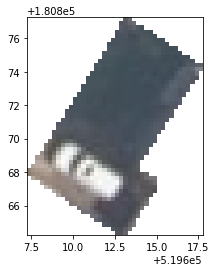

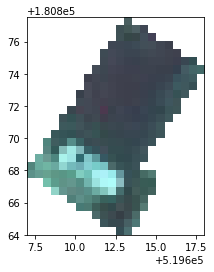

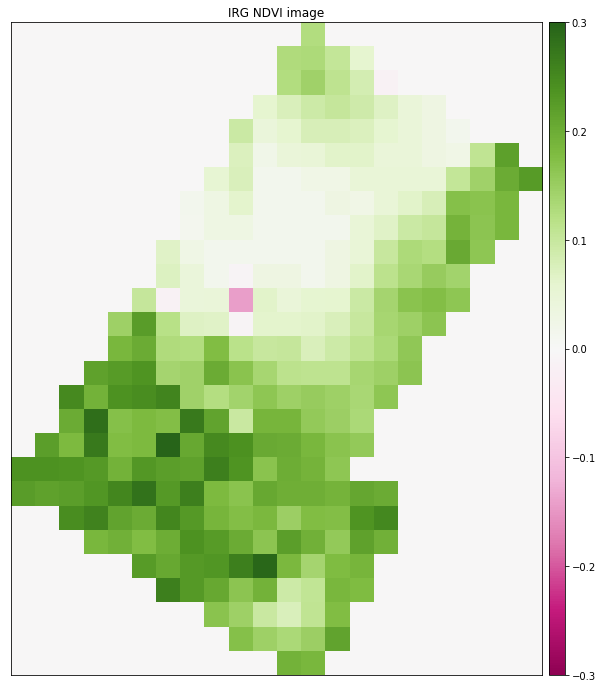

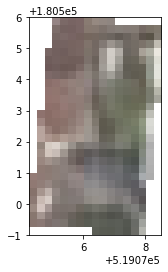

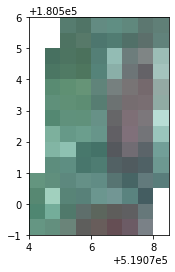

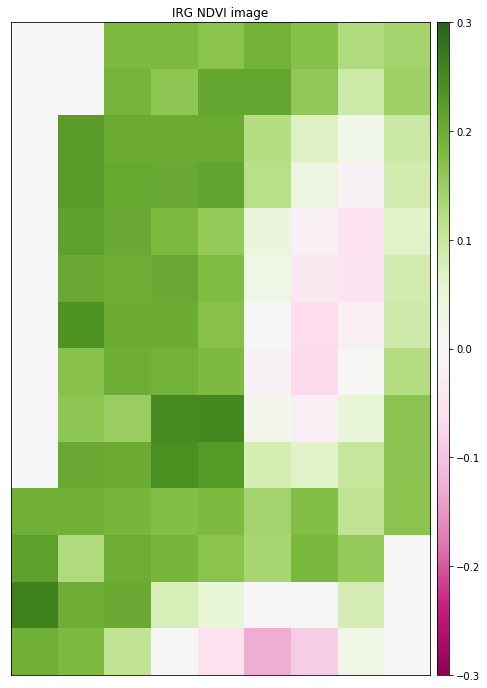

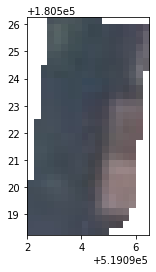

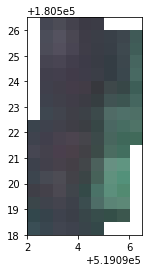

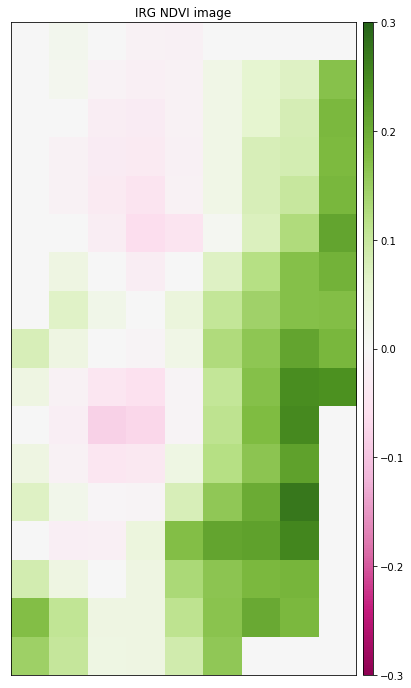

In [308]:
for i in np.arange(5):
    rgbim = rasterio.open(rgb_cg_paths[i]) #read RGB image
    plot.show(rgbim) #plot image

    im = rasterio.open(irg_cg_paths[i]) #read IRG image
    plot.show(im) #plot image
    im_data = im.read().astype(np.float) #assign data array to object & convert to float
    im_ndvi = es.normalized_diff(im_data[1], im_data[0]) #calc NDVI
    
    #plot
    ep.plot_bands(im_ndvi
              , cmap='PiYG' #a diverging colourmap
              , scale=False
              , vmin=-0.3, vmax=0.3
              , title="IRG NDVI image")
    plt.show()
    

## Histograms

These show the number of pixels in the image with each value, total pixels in this image 20 x 34 = 680

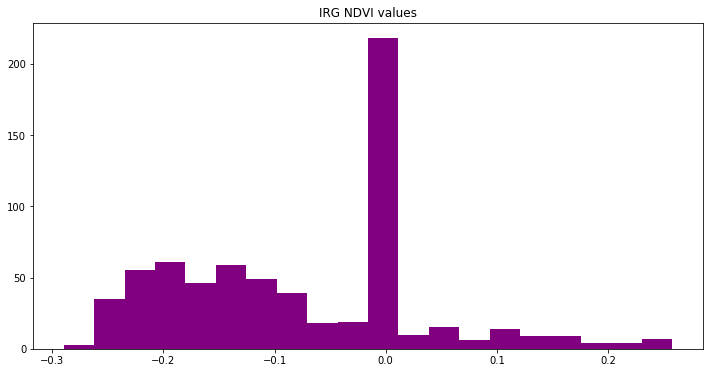

In [309]:
ep.hist(irg_ndvi,
        figsize=(12, 6),
        title=["IRG NDVI values"])

plt.show()

#NDVI values should be in [-1, 1], they are now!

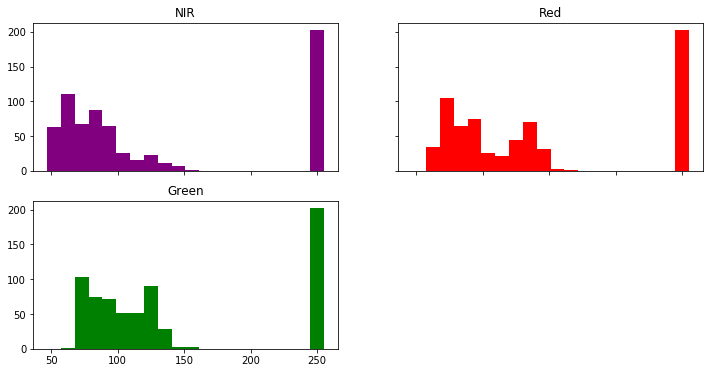

In [310]:
ep.hist(irg_data
        , figsize=(12, 6)
        , colors = ['purple', 'red', 'green']
        , title=["NIR", "Red", "Green"])

plt.show()
#Ths is not helpful. 

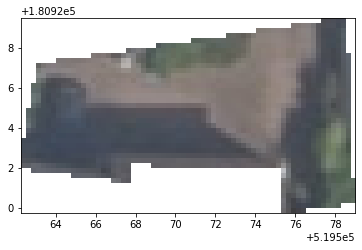

In [311]:
plot.show(rgb)

## SciKit-image

In [312]:
sk_irg = skimage.io.imread(fname=irg_cg_paths[0])

In [313]:
sk_irg.shape
#reads it in the other way...fkw

(20, 34, 3)

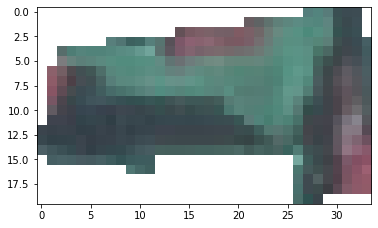

In [314]:
plt.imshow(sk_irg)


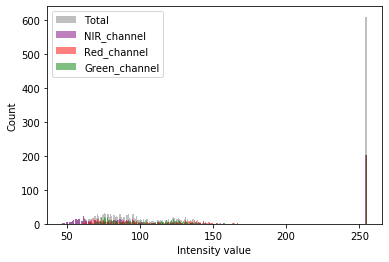

In [315]:
_ = plt.hist(sk_irg.ravel(), bins = 256, color = 'gray', alpha = 0.5)
_ = plt.hist(sk_irg[:, :, 0].ravel(), bins = 256, color = 'purple', alpha = 0.5)
_ = plt.hist(sk_irg[:, :, 1].ravel(), bins = 256, color = 'red', alpha = 0.5)
_ = plt.hist(sk_irg[:, :, 2].ravel(), bins = 256, color = 'green', alpha = 0.5)
_ = plt.xlabel('Intensity value')
_ = plt.ylabel('Count')
_ = plt.legend(['Total', 'NIR_channel', 'Red_channel', 'Green_channel'])
plt.show()

### Chop off values for 255

No idea how to interpret these histograms

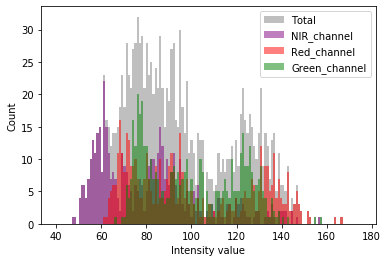

In [316]:
n_bins = 175 - 40 + 1
h_range = [40, 175]

_ = plt.hist(sk_irg.ravel(), bins = n_bins, range = h_range, color = 'gray', alpha = 0.5)
_ = plt.hist(sk_irg[:, :, 0].ravel(), bins = n_bins, range = h_range, color = 'purple', alpha = 0.5)
_ = plt.hist(sk_irg[:, :, 1].ravel(), bins = n_bins, range = h_range, color = 'red', alpha = 0.5)
_ = plt.hist(sk_irg[:, :, 2].ravel(), bins = n_bins, range = h_range, color = 'green', alpha = 0.5)
_ = plt.xlabel('Intensity value')
_ = plt.ylabel('Count')
_ = plt.legend(['Total', 'NIR_channel', 'Red_channel', 'Green_channel'])
plt.show()

## cv2

OpenCV uses BGR ordering, fkw. 

https://stackoverflow.com/questions/59728357/ndvi-value-calculation-and-image-processing

In [317]:
cv2im = cv2.imread(irg_cg_paths[0]).astype(np.float)

In [318]:
cv2im.shape

(20, 34, 3)

In [320]:
cv2im[0:3, 0:3, 0:3]
#In terms of the image I think this is 
#from top left down 3 pixels
#from top left right 3 pixels
#the I, R, G values for each - these are all 255 since these 9 pixels are outside the gdn space

array([[[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]]])

cv2 channel order is stored as Green, Red, NIR

In [321]:
# Split into 3 channels, remember order is Green, Red, NIR
_, Red, NearIR = cv2.split(cv2im)

# Compute NDVI values for each pixel
cv2im_ndvi = (NearIR - Red) / (NearIR + Red + 0.001) #the extra 0.001 deals with zeros in denominator

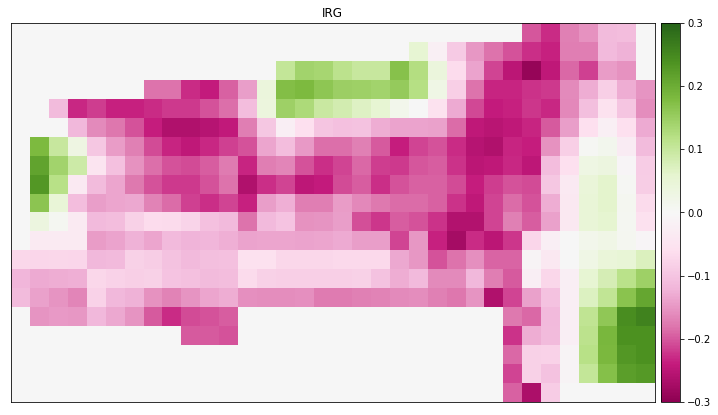

In [323]:
ep.plot_bands(cv2im_ndvi
              , cmap='PiYG'
              , scale=False
              , vmin = -0.3, vmax=0.3
              , title="IRG")
plt.show()
#scale = True forces scale to use full range of colours, so it's mostly white
#vmin and vmax fix the range to use for the colour scale
#keep in mind that the colour scale used here is arbitrary, the NDVI values are not changed
#0 NDVI is still the cut-off, with NDVI >0 indicating vegetation

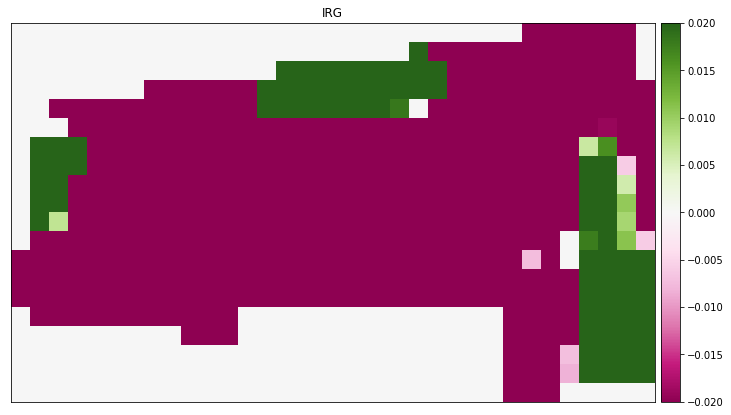

In [324]:
#try with a tighter vmin, vmax to see the difference
ep.plot_bands(cv2im_ndvi
              , cmap='PiYG'
              , scale=False
              , vmin = -0.02, vmax=0.02
              , title="IRG")
plt.show()

In [325]:
cv2im_ndvi.shape

(20, 34)

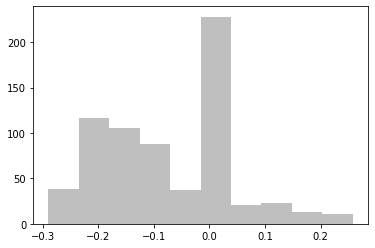

In [326]:
#ravel() flattens an array - gets all the numbers out of it into one list of numbers
_ = plt.hist(cv2im_ndvi.ravel(), bins = 10, color = 'gray', alpha = 0.5)
plt.show()

In [329]:
#this looks better, I have negatives, and nothing outside [-1,1]
#range seems wider than when I had the channels mixed up and was doing Green & Red
#[-.3, 0.3]
print("min:"
      , np.amin(cv2im_ndvi[~np.isnan(cv2im_ndvi)])
      , "and max:"
      , np.amax(cv2im_ndvi[~np.isnan(cv2im_ndvi)])
     )


min: -0.28971827234452174 and max: 0.2579173849892082


## Try cv2 method on 5 images

This looks a lot better
- range is good [-1,1], negatives and positves
- no NaNs
- Values seem to be generally very small, in [-0.1, 0.1]

Keep in mind that the **colour scale used in these plots is arbitrary**, the NDVI values are not changed; 0 NDVI is still the cut-off, with NDVI >0 indicating vegetation. I need to decide if I use 0 as the cut off or go slightly above. 


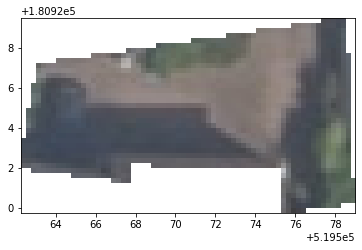

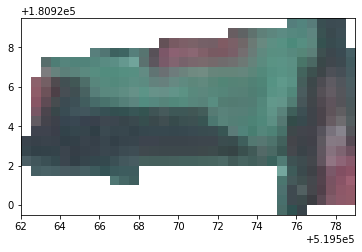

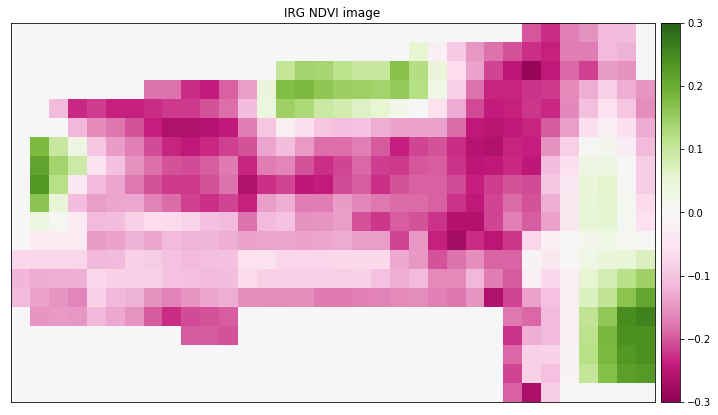

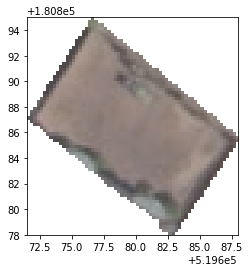

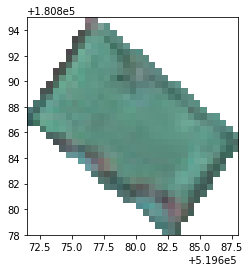

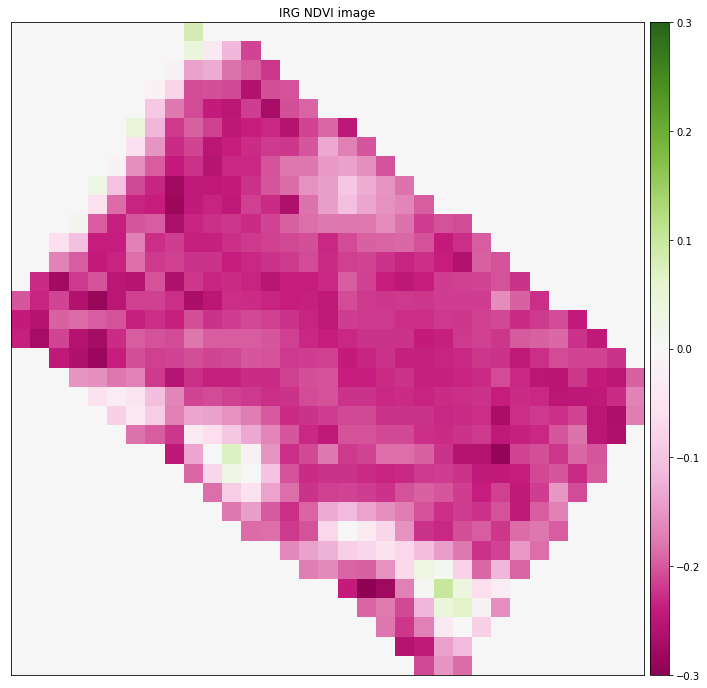

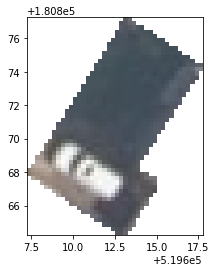

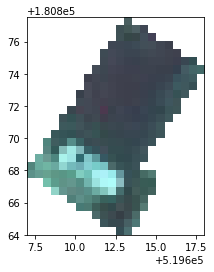

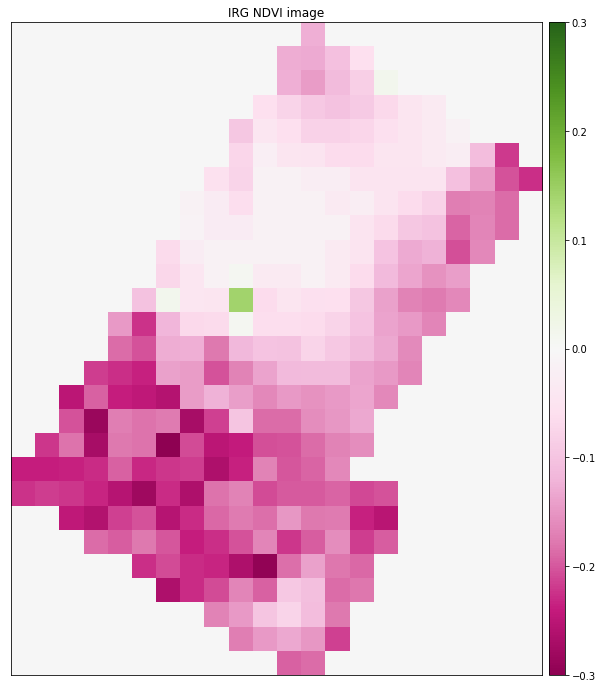

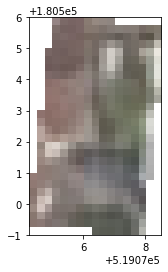

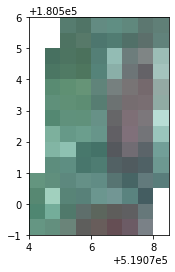

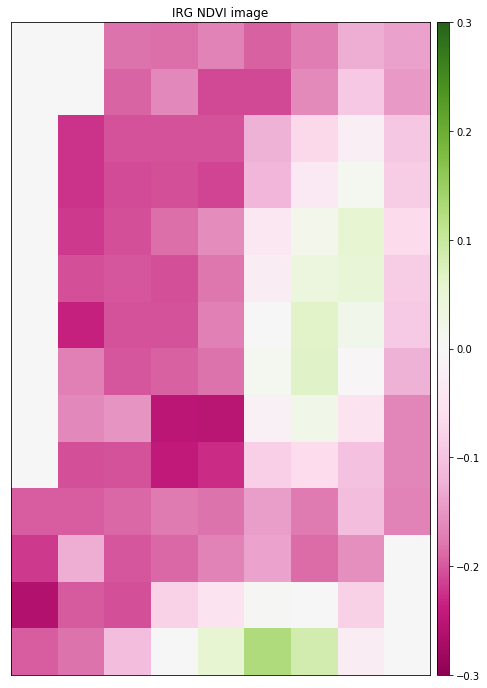

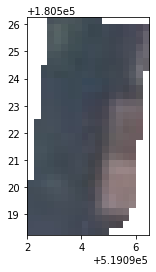

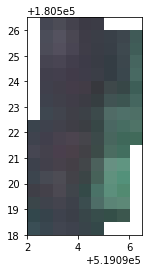

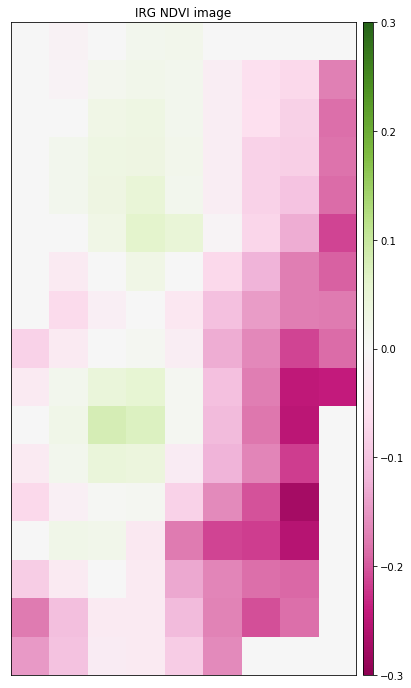

In [331]:
for i in np.arange(5):
    rgb_im = rasterio.open(rgb_cg_paths[i]) #read RGB image
    plot.show(rgb_im) #plot RGB image

    irg_im = rasterio.open(irg_cg_paths[i]) #read IRG image
    plot.show(irg_im) #plot IRG image
    
    im = cv2.imread(irg_cg_paths[i]).astype(np.float) #read IRG with cv2 & convert to float
    # Split into 3 channels, remember cv2 order is Green, Red, NIR
    _, Red, NearIR = cv2.split(im)

    # Compute NDVI values for each pixel
    im_ndvi = (NearIR - Red) / (NearIR + Red + 0.001) # guess the extra 0.001 deals with zeros
    #this must lose the CRS
    
    #plot
    ep.plot_bands(im_ndvi
              , cmap='PiYG' #a diverging colourmap
              , scale=False
              , vmin = -0.3
              , vmax = 0.3
              , title="IRG NDVI image")
    plt.show()
    

## Histogram of NDVI values from 1000 images

Take 1000 images, calculate NDVI values, ravel and append, so I have one list of all NDVI values across all these images. Then plot hist

Number of NDVI vlaues in plot: 535148


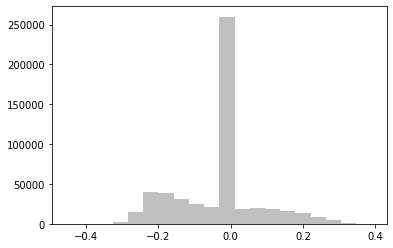

In [332]:
#initiate array of ndvi values
ndvis = []

for i in np.arange(1000):
    
    im = cv2.imread(irg_cg_paths[i]).astype(np.float) #read IRG with cv2 & convert to float
    # Split into 3 channels, remember cv2 order is Green, Red, NIR
    _, Red, NearIR = cv2.split(im)

    # Compute NDVI values for each pixel
    im_ndvi = (NearIR - Red) / (NearIR + Red + 0.001) # guess the extra 0.001 deals with zeros
    
    #flatten and append array
    ndvis = np.append(ndvis, im_ndvi.ravel());

#print shape and plot hist
print("Number of NDVI vlaues in plot:", ndvis.shape[0])

_ = plt.hist(ndvis.ravel(), bins = 20, color = 'gray', alpha = 0.5)
plt.show()

In [337]:
print("1000 images min NDVI: ", min(ndvis), "\n1000 images max NDVI: ", max(ndvis))

1000 images min NDVI:  -0.4518485048258902 
1000 images max NDVI:  0.38966953206792454


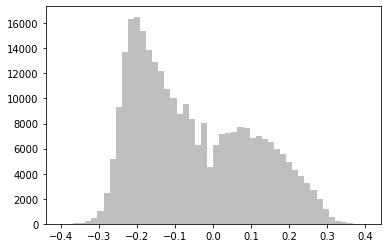

In [336]:
#drop all zeroes from NDVI values array then plot
_ = plt.hist(ndvis[ndvis != 0] #drop zeros
             , bins = 50
             , range = [-0.4, 0.4]
             , color = 'gray'
             , alpha = 0.5)
plt.show()

### Summary of NIR & Red NDVI calculation over 1000 images

- range of 1000 of the plots in the TQ1980 area is [-0.4, 0.4] to the nearest 1dp. 
- peak is negative, indicating more pixels with non-vegetation

#### Removed peak at zero
- the peak at zero is due to the non-garden space being set to white (255 on all channels); so it's NDVI value is 0, should mostly ignore this. This is a large area on all images, due to images being not aligned vertically/horizontally.
- In theory I should take the NDVI value threshold as 0, and anything >0 is vegetation and anything <=0 is not. But in practise I think I may want it to be a little off zero. Or I could ignore zero. >0 is veg, <0 is not, =0 is something else. 
- how likely is it for 'natural' zero NDVI to occur? This is when the NIR and Red value are equal.

### Summary of INCORRECT Green & Red NDVI calc over 1000 images

Summary of above plots and hhistograms when I mistakenly used Green & Red instead of NIR and Red in the NDVI cv2 calcualtion.

- range of 1000 of the plots in the TQ1980 area is [-0.4, 0.2] to the nearest 1dp. Clearly most of the data is in a smaller range of approximately [-0.1, 0.1]
- the peak at zero is due to the non-garden space being set to white (255 on all channels); so it's NDVI value is 0, should mostly ignore this. This is a large area on all images, due to images being not aligned vertically/horizontally.
- In theory I should take the NDVI value threshold as 0, and anything >0 is vegetation and anything <=0 is not. But in practise I think I may want it to be a little off zero. Or I could ignore zero. >0 is veg, <0 is not, =0 is something else. 
- how likely is it for 'natural' zero NDVI to occur? This is when the NIR and Red value are equal.


### Plot histogram without zeros

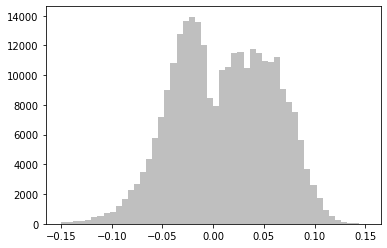

In [110]:
#INCORRECT - uses Green & Red (instead of NIR & Red)
#drop all zeroes from NDVI values array then plot
#_ = plt.hist(ndvis[ndvis != 0] #drop zeros
#             , bins = 50
#             , range = [-0.15, 0.15]
#             , color = 'gray'
#             , alpha = 0.5)
#plt.show()

## How likely are 'natural' zero value NDVI

This occurs when the NIR and Red channel values are equal.

- read in some images
- take NIR, Red and Green  channel values
- ravel and append separately then zip into a df
- drop rows where NIR == Red == Green == 255 - these are the white values
- Now compare remaining NIR and Red for equality; these will give NDVI value = 0.
- calculate prop o f 'natural' zeros.

In [338]:
#initiate array of ndvi values
nir = []
red = []
grn = []

#collect NIR, Red and Green values from several images
for i in np.arange(1000):
    
    im = cv2.imread(irg_cg_paths[i]).astype(np.float) #read IRG with cv2 & convert to float
    # Split into 3 channels, remember cv2 order Green, Red, NIR
    Green, Red, NearIR = cv2.split(im)
    
    #ravel and append
    nir = np.append(nir, NearIR.ravel())
    red = np.append(red, Red.ravel())
    grn = np.append(grn, Green.ravel());
    

In [339]:
#make into df
irg_multi = pd.DataFrame(
    {'NIR' : nir, 'Red' : red, 'Green' : grn}
)

#select only those rows where all values not equal to 255
#this drops all the 'unnatural' white occurances
irg_multi = irg_multi.loc[
    ~( (irg_multi['NIR'] == 255.0) & (irg_multi['Red'] == 255.0) & (irg_multi['Green'] == 255.0) )
    , :
]

#create col with diff of NIR and Red
irg_multi['NIR_Red_diff'] = irg_multi['NIR'] - irg_multi['Red']

#just take remaining zeros
natural_zeros = irg_multi.loc[
    irg_multi['NIR_Red_diff'] == 0
    , :
]

print(
    "Proportion of natural 0 NDVI values:"
    , natural_zeros.shape[0] / irg_multi.shape[0]
)

Proportion of natural 0 NDVI values: 0.01230108664686012


In [340]:
natural_zeros.head()

,NIR,Red,Green,NIR_Red_diff
157,112.0,112.0,112.0,0.0
172,124.0,124.0,126.0,0.0
403,67.0,67.0,75.0,0.0
437,65.0,65.0,73.0,0.0
690,127.0,127.0,129.0,0.0


In [341]:
natural_zeros.shape

(3627, 4)

### CORRECT summary using NIR & Red for NDVI

So natural zero NDVI does exist

- only need NIR and Red channel values to be equal to get NDVI = 0
- accounts for about 1% of values, after the unnatural zeros have been removed.
- is this small enough to ignore?
- best method is probably to intersect shape with original cropped garden shape again

### INCORRECT summary using Green & Red for NDVI

So natural zero NDVI does exist

- only need NIR and Red channel values to be equal to get NDVI = 0
- accounts for about 3% of values. 
- is this small enough to ignore?
- best method is probably to intersect shape with original cropped garden shape again

## Segment image at NDVI threshold 0

Try to segment the image taking the simple threshold
- NDVI > 0 == vegetation
- NDVI <= 0 == manmade surface

#### Using rasterio to mask and polygonise a raster
https://gis.stackexchange.com/questions/187877/how-to-polygonize-raster-to-shapely-polygons

Ought to be able to create a mask, using the NDVI threshold, then create polygons from this. Need to do this to see how to do it and to see what I get. Then think about do I want to add some imag processing steps in between.

### Try using rasterio only

https://rasterio.readthedocs.io/en/latest/topics/features.html

In [136]:
#load source image
im = rasterio.open(irg_cg_paths[0])
print("path: ", im.name, "\nmode: ", im.mode, "\nis closed?: ", im.closed
      , "\nband count: ", im.count, "\nshape: ", im.shape, "\nCRS: ", im.crs )

path:  ../jigsaw_output/irg_gdn_cropped/TQ1980_1000001778697829.tif 
mode:  r 
is closed?:  False 
band count:  3 
shape:  (20, 34) 
CRS:  EPSG:27700


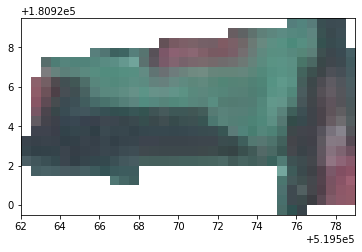

In [137]:
#start with single CIR 50cm resolution image loaded using rasterio above
plot.show(im)

In [152]:
#separate the data - this returns a np array
imdata = im.read().astype(np.float)

In [153]:
type(imdata)

numpy.ndarray

In [154]:
imdata.shape
# 3 channels: NIR, Red, Green
# height: starts top left and goes down
# width: starts top left and goes right
#datum is tope left

(3, 20, 34)

In [155]:
imdata[:, 0:3, 0:3]
#top left corner 9 pixels, all white as outside garden space.

array([[[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]]])

In [156]:
#separate NIR and Red channels
nir_imdata = imdata[0]
red_imdata = imdata[1]

In [157]:
nir_imdata.shape
red_imdata.shape

(20, 34)

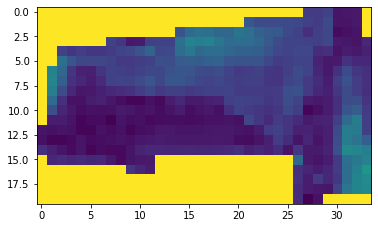

In [158]:
#this uses rasterio plot, no idea how to adjust colour used
plot.show(nir_imdata)

In [159]:
#create NDVI array
ndvi_imdata = (nir_imdata - red_imdata) / (nir_imdata + red_imdata + 0.001)

In [160]:
ndvi_imdata.shape

(20, 34)

In [161]:
ndvi_imdata

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -0.19999905, -0.22790592, -0.16981052,
        -0.15328355, -0.11111029, -0.10948825,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.05583728, -0.02061845, -0.09090866, -0.1479814 ,
        -0.18061594, -0.20346232, -0.22522421, -0.23502196, -0.17180541,
        -0.17142735, -0.11450294, -0.12230128,  0.        ],
  

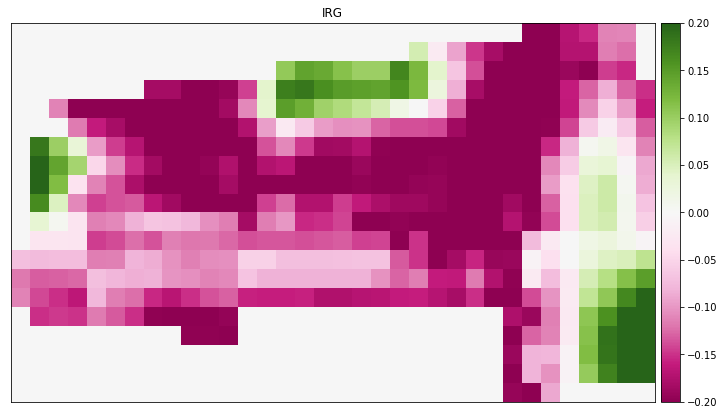

In [173]:
#use ep to plot
ep.plot_bands(ndvi_imdata
              , cmap='PiYG'
              , scale=False
              , vmin = -0.2, vmax=0.2
              , title="IRG")
plt.show()

### Compare to cv2 read image

In [342]:
cv2im = cv2.imread(irg_cg_paths[0]).astype(np.float)

# Split into 3 channels, discarding the third and saving the second as R, first as NearIR
_, Red, NearIR = cv2.split(cv2im)
#if this has read in as B, G, R then 

# Compute NDVI values for each pixel
cv2im_ndvi = (NearIR - Red) / (NearIR + Red + 0.001) #the extra 0.001 deals with zeros in denominator

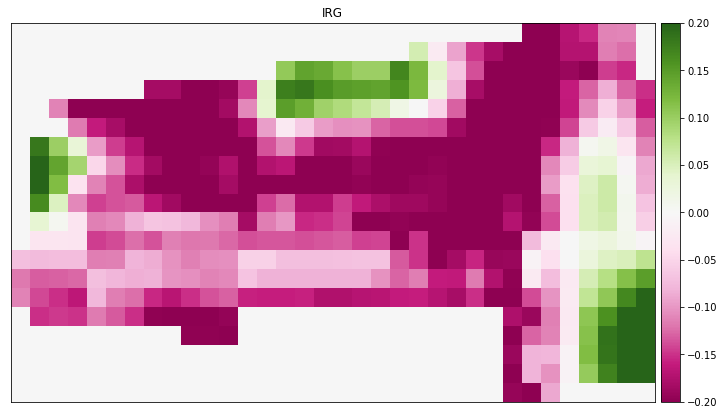

In [343]:
#use ep to plot
ep.plot_bands(cv2im_ndvi
              , cmap='PiYG'
              , scale=False
              , vmin = -0.2, vmax=0.2
              , title="IRG")
plt.show()

In [344]:
cv2im_ndvi.shape

(20, 34)

In [346]:
#compare N
cv2im_ndvi[0,:]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.19999905, -0.22790592, -0.16981052,
       -0.15328355, -0.11111029, -0.10948825,  0.        ])

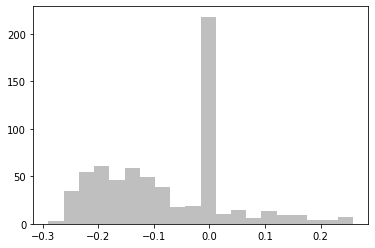

In [347]:
_ = plt.hist(ndvi_imdata.ravel(), bins = 20, color = 'gray', alpha = 0.5)
plt.show()

In [116]:
#start with 
cv2irg = cv2.imread(irg_cg_paths[0]).astype(np.float)

## Compare NDVI calculations in rasterio and cv2

In [348]:
cv2im_ndvi.shape

(20, 34)

In [349]:
ndvi_imdata.shape

(20, 34)

In [350]:
cv2im_ndvi[0,:]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.19999905, -0.22790592, -0.16981052,
       -0.15328355, -0.11111029, -0.10948825,  0.        ])

In [351]:
ndvi_imdata[0,:]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.19999905, -0.22790592, -0.16981052,
       -0.15328355, -0.11111029, -0.10948825,  0.        ])

In [359]:
sum(sum(cv2im_ndvi == ndvi_imdata)) == ndvi_imdata.shape[0] * ndvi_imdata.shape[1]
#Thank the maker, the NDVI values agree!!!

True

## Compare channel data in rasterio and cv2

cv2 expects images to be in R,G,B order when reading them in and then it reorders them to B, G, R order so it maps

- 0 -> 2
- 1 -> 1
- 2 -> 0

In [244]:
irg_data.shape
#channel, height, width

(3, 20, 34)

In [245]:
cv2im.shape
#height, width, channel

(20, 34, 3)

In [269]:
#NIR is channel 0 in irg_data read in with rasterio
irg_data[0,1,:]

array([255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255.,
       255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 104.,
        95.,  95.,  95.,  93.,  92.,  86.,  83.,  94.,  58.,  58.,  61.,
       255.])

In [270]:
#NIR is channel 2 in cv2
cv2im[1,:,2]

array([255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255.,
       255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 104.,
        95.,  95.,  95.,  93.,  92.,  86.,  83.,  94.,  58.,  58.,  61.,
       255.])

In [358]:
#check channels match - THEY DO!!!
#check NIR channels match 0 in rasterio, 2 in cv2
print(sum(sum(irg_data[0,:,:] == cv2im[:,:,2])) == irg_data.shape[1] * irg_data.shape[2])

#check Red channels match 1 in rasterio, 1 in cv2
print(sum(sum(irg_data[1,:,:] == cv2im[:,:,1])) == irg_data.shape[1] * irg_data.shape[2])

#check Red channels match 2 in rasterio, 0 in cv2
print(sum(sum(irg_data[2,:,:] == cv2im[:,:,0])) == irg_data.shape[1] * irg_data.shape[2])

True
True
True


# ARCHIVE

### Image processing cv2

These methods seem to use the complete colour space and ignore the NDVI values, since they are general methods and not specifically for vegetation, or using NIR channels. ONS used NIR, Green and Blue channels. I think using the NIR channel instead of the Red channel provided more vegetation related intensity values. I think with RGB scheme each channel is the intensity, in [0,255] of the base colour in that channel.

So I take ONS approach, swap out Red for NIR then use a variety of openCV methods to segment and tidy images.

OpenCV docs; image processing chapter is the one
https://readthedocs.org/projects/opencv-python-tutroals/downloads/pdf/latest/

opencv colorspace docs
https://docs.opencv.org/master/d8/d01/group__imgproc__color__conversions.html

read this on colour segmentation
https://realpython.com/python-opencv-color-spaces/

In [57]:

#print all the colour space transformations available in cv2
flags = [i for i in dir(cv2) if i.startswith('COLOR_')]
print("There are", len(flags), "colour space transformations in cv2. For example:", flags[0:5])

there are 274 colour space transformations in cv2. For example: ['COLOR_BAYER_BG2BGR', 'COLOR_BAYER_BG2BGRA', 'COLOR_BAYER_BG2BGR_EA', 'COLOR_BAYER_BG2BGR_VNG', 'COLOR_BAYER_BG2GRAY']


## Bilateral filtering
http://people.csail.mit.edu/sparis/bf_course/